# Progetto Fashion

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np #lo uso per fare la differenza di date in mesi
from statsmodels.tsa.seasonal import seasonal_decompose
import os
os.environ["OMP_NUM_THREADS"] = '1' #messo prima di kmeans per evitare warning su pc windows 
from sklearn.cluster import KMeans
import altair as alt

In [2]:
fashion_data_raw = pd.read_csv('data/Fashion_data Final Project.csv')

In [3]:
fashion_data = fashion_data_raw.copy()

In [4]:
fashion_data.shape

(999, 11)

In [5]:
fashion_data.head()

,user_uuid,category,designer_id,language,level,country,purchase_date,platform,item_id,stars,subscription_date
0,183,belt,120,en,cheap,uk,13-7-2022,android,3521,1,20-8-2021
1,134,underwear,102,it,cheap,it,2-5-2023,android,6239,2,20-11-2022
2,158,belt,106,it,cheap,it,6-8-2021,pc,3618,3,18-3-2020
3,82,shoes,102,it,premium,it,18-7-2023,android,5281,4,21-1-2022
4,201,shoes,113,en,average,uk,7-5-2023,android,5260,1,25-11-2022


## Data Cleaning

Esamino la struttura del dataset per verificare i tipi di dati, la presenza di valori mancanti o campi duplicati.

In [6]:
fashion_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_uuid          999 non-null    int64 
 1   category           999 non-null    object
 2   designer_id        999 non-null    int64 
 3   language           999 non-null    object
 4   level              999 non-null    object
 5   country            999 non-null    object
 6   purchase_date      999 non-null    object
 7   platform           999 non-null    object
 8   item_id            999 non-null    int64 
 9   stars              999 non-null    int64 
 10  subscription_date  999 non-null    object
dtypes: int64(4), object(7)
memory usage: 86.0+ KB


In [7]:
# Valori mancanti
fashion_data.isnull().sum()

user_uuid            0
category             0
designer_id          0
language             0
level                0
country              0
purchase_date        0
platform             0
item_id              0
stars                0
subscription_date    0
dtype: int64

In [8]:
# Valori duplicati
fashion_data.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
994    False
995    False
996    False
997    False
998    False
Length: 999, dtype: bool

In [9]:
fashion_data.duplicated().sum()

0

Mi sono assicurato che nel dataset non ci siano righe duplicate e, inoltre, ho verificato l'assenza di valori mancanti.
Ora esaminerò i tipi di dati, in particolare le colonne di tipo "object", per valutare la possibilità di convertirle in "categorical" o "datetime".

In [10]:
fashion_data['category'].value_counts()

category
belt          339
shoes         165
bottom        135
dress         128
activewear     93
shirt          82
underwear      57
Name: count, dtype: int64

In [11]:
fashion_data['category'] = fashion_data['category'].astype('category')

In [12]:
fashion_data['language'].value_counts()

language
it    451
en    337
fr    211
Name: count, dtype: int64

In [13]:
fashion_data['level'].value_counts()

level
premium    433
cheap      332
average    234
Name: count, dtype: int64

In [14]:
fashion_data['level'] = fashion_data['level'].astype('category')

In [15]:
fashion_data['country'].value_counts()

country
it    451
uk    337
fr    211
Name: count, dtype: int64

In [16]:
fashion_data['country'] = fashion_data['country'].astype('category')

In [17]:
fashion_data['platform'].value_counts()

platform
android    458
pc         330
apple      211
Name: count, dtype: int64

In [18]:
fashion_data['platform'] = fashion_data['platform'].astype('category')

In [19]:
fashion_data['purchase_date'] = pd.to_datetime(fashion_data['purchase_date'], dayfirst=True)

In [20]:
fashion_data['subscription_date'] = pd.to_datetime(fashion_data['subscription_date'], dayfirst=True)

In [21]:
fashion_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_uuid          999 non-null    int64         
 1   category           999 non-null    category      
 2   designer_id        999 non-null    int64         
 3   language           999 non-null    object        
 4   level              999 non-null    category      
 5   country            999 non-null    category      
 6   purchase_date      999 non-null    datetime64[ns]
 7   platform           999 non-null    category      
 8   item_id            999 non-null    int64         
 9   stars              999 non-null    int64         
 10  subscription_date  999 non-null    datetime64[ns]
dtypes: category(4), datetime64[ns](2), int64(4), object(1)
memory usage: 59.4+ KB


Questa rappresenta la struttura del dataset dopo il processo di pulizia.

## Exploratory Data analysis

In [22]:
fashion_data.head()

,user_uuid,category,designer_id,language,level,country,purchase_date,platform,item_id,stars,subscription_date
0,183,belt,120,en,cheap,uk,2022-07-13,android,3521,1,2021-08-20
1,134,underwear,102,it,cheap,it,2023-05-02,android,6239,2,2022-11-20
2,158,belt,106,it,cheap,it,2021-08-06,pc,3618,3,2020-03-18
3,82,shoes,102,it,premium,it,2023-07-18,android,5281,4,2022-01-21
4,201,shoes,113,en,average,uk,2023-05-07,android,5260,1,2022-11-25


In [23]:
fashion_data.describe()

,user_uuid,designer_id,purchase_date,item_id,stars,subscription_date
count,999.000000,999.000000,999,999.000000,999.000000,999
mean,126.206206,110.769770,2023-01-01 10:52:58.378378240,4032.721722,3.013013,2021-06-22 10:11:10.270270208
min,1.000000,100.000000,2021-01-01 00:00:00,26.000000,1.000000,2020-01-02 00:00:00
25%,69.000000,105.000000,2022-06-26 00:00:00,2248.000000,2.000000,2020-12-01 00:00:00
50%,128.000000,111.000000,2023-02-26 00:00:00,3662.000000,3.000000,2021-06-05 00:00:00
75%,183.500000,116.000000,2023-07-28 00:00:00,5972.500000,4.000000,2022-02-18 00:00:00
max,245.000000,122.000000,2023-12-28 00:00:00,11000.000000,5.000000,2022-12-23 00:00:00
std,68.581911,6.623049,NaN,2266.843497,1.415216,NaN


In [24]:
# Inventario degli utenti
fashion_data.groupby('user_uuid').size().sort_values(ascending = False)

user_uuid
182    11
131    10
190    10
119    10
225     9
       ..
214     1
85      1
68      1
203     1
76      1
Length: 241, dtype: int64

Il dataset è composto da 999 vendite e coinvolge 241 utenti.

Ora, sono interessato a capire se un singolo utente abbia la possibilità di vendere in nazioni diverse e se correttamente presenta la stessa "subscription_date" per ogni vendita. A tale scopo, prendo come campione casuale del dataset l'utente con il maggior numero di vendite, identificato da "user_uuid" 182.

In [25]:
fashion_data.loc[fashion_data['user_uuid'] == 182]

,user_uuid,category,designer_id,language,level,country,purchase_date,platform,item_id,stars,subscription_date
77,182,activewear,112,en,premium,uk,2021-06-15,android,6150,1,2020-03-14
130,182,bottom,120,en,average,uk,2023-07-27,android,1531,3,2020-03-14
286,182,shoes,122,it,cheap,it,2022-06-11,android,5778,4,2020-03-14
395,182,belt,117,it,premium,it,2022-02-11,android,3241,1,2020-03-14
430,182,bottom,112,en,average,uk,2022-08-22,android,1633,5,2020-03-14
...,...,...,...,...,...,...,...,...,...,...,...
526,182,shirt,110,en,premium,uk,2021-06-11,pc,2569,3,2020-03-14
611,182,belt,109,en,premium,uk,2021-11-05,android,3253,3,2020-03-14
862,182,belt,118,it,premium,it,2021-08-23,pc,3226,3,2020-03-14
914,182,belt,118,it,average,it,2023-07-01,apple,3111,1,2020-03-14


Ho effettivamente verificato che un singolo utente può vendere prodotti in mercati diversi (utilizzando quindi lingue differenti). L'utente in questione presenta correttamente la stessa "subscription_date" per ogni vendita. 
Mi occuperò di quest'ultima analisi più nel dettaglio successivamente.

## Iscrizioni annuali

In [26]:
user_subscription = fashion_data.loc[:, ['user_uuid', 'subscription_date']].drop_duplicates()
user_subscription['subscription_date'] = user_subscription['subscription_date'].dt.year
#user_subscription

In [27]:
user_subscription = user_subscription.groupby('subscription_date').size()
#user_subscription 

Text(0, 0.5, 'Total')

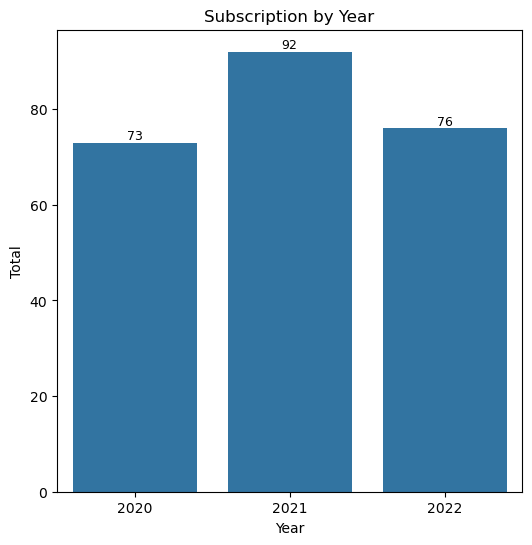

In [28]:
plt.figure(figsize = (6,6))
plt.title('Subscription by Year')
ax = sns.barplot(x = user_subscription.index, y = user_subscription, color = 'tab:blue')
ax.bar_label(ax.containers[0], fontsize=9)
ax.set_xlabel('Year')
ax.set_ylabel('Total')

Il picco di iscrizioni è avvenuto nel 2021. Sommando il numero degli utenti nei tre anni, otteniamo 241, che corrisponde, come detto in precedenza, al numero degli utenti nel dataset.

## Analisi delle Iscrizioni

Vorrei generare un grafico che illustri l'andamento mensile delle iscrizioni nel corso degli anni. Successivamente, intendo esaminare la presenza o l'assenza di un trend o di una stagionalità nelle iscrizioni.

In [29]:
subscriptions = fashion_data.loc[:, ['user_uuid', 'subscription_date']]
subscriptions['subscription_date'].min(), subscriptions['subscription_date'].max()

(Timestamp('2020-01-02 00:00:00'), Timestamp('2022-12-23 00:00:00'))

In [30]:
subscriptions.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
994     True
995     True
996     True
997     True
998     True
Length: 999, dtype: bool

In [31]:
subscriptions.drop_duplicates(inplace = True)
subscriptions.shape

(241, 2)

In [32]:
subscriptions = subscriptions.groupby('subscription_date')['user_uuid'].count().reset_index()
subscriptions = subscriptions.rename(columns = {'user_uuid': '# users'})
subscriptions

,subscription_date,# users
0,2020-01-02,1
1,2020-01-06,1
2,2020-01-08,1
3,2020-01-09,1
4,2020-01-11,1
...,...,...
215,2022-11-28,2
216,2022-12-09,1
217,2022-12-17,1
218,2022-12-19,1


In [33]:
subscriptions = subscriptions.set_index('subscription_date')
subscriptions

,# users
subscription_date,
2020-01-02,1
2020-01-06,1
2020-01-08,1
2020-01-09,1
2020-01-11,1
...,...
2022-11-28,2
2022-12-09,1
2022-12-17,1


In [34]:
subscriptions_resampled = subscriptions['# users'].resample('MS').sum()
subscriptions_resampled

subscription_date
2020-01-01     6
2020-02-01     6
2020-03-01     8
2020-04-01     6
2020-05-01     5
2020-06-01     4
2020-07-01     6
2020-08-01     6
2020-09-01     4
2020-10-01     6
2020-11-01     7
2020-12-01     9
2021-01-01    10
2021-02-01    10
2021-03-01     3
2021-04-01     6
2021-05-01    13
2021-06-01     7
2021-07-01    11
2021-08-01     6
2021-09-01     8
2021-10-01     9
2021-11-01     4
2021-12-01     5
2022-01-01     7
2022-02-01     5
2022-03-01    10
2022-04-01     3
2022-05-01    10
2022-06-01     5
2022-07-01     6
2022-08-01     7
2022-09-01     7
2022-10-01     3
2022-11-01     9
2022-12-01     4
Freq: MS, Name: # users, dtype: int64

In [35]:
subscriptions_resampled.sum()

241

<Axes: title={'center': 'Subscription Trend'}, xlabel='subscription_date', ylabel='# users'>

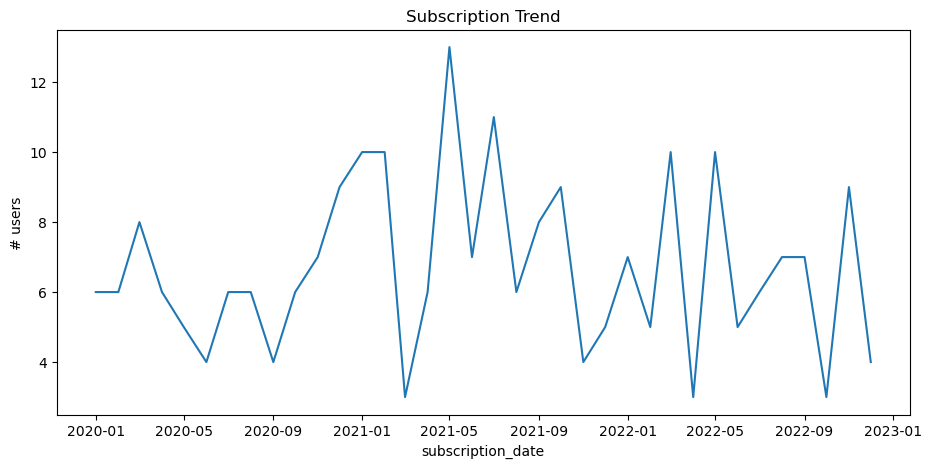

In [36]:
plt.figure(figsize = (11,5))
plt.title('Subscription Trend')
sns.lineplot(data = subscriptions_resampled)

## Trend e Stagionalità nelle Iscrizioni

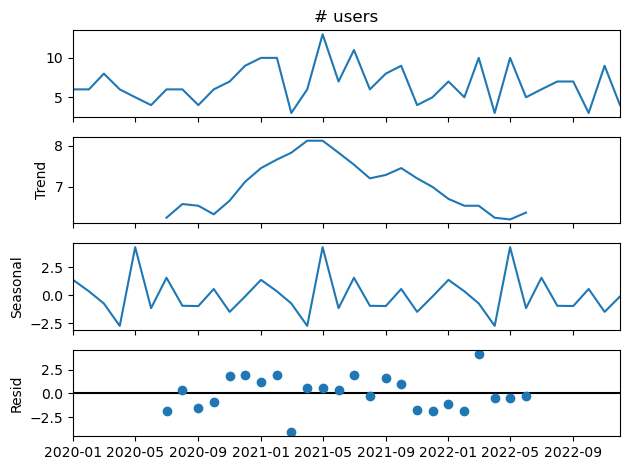

In [37]:
decomposition_sub = seasonal_decompose(subscriptions_resampled)
fig = decomposition_sub.plot()
plt.show()

Dall'analisi dell'immagine precedente emerge chiaramente la presenza di una stagionalità annuale, con un picco di iscrizioni evidente in determinati periodi dell'anno. Possiamo anche dedurre che: 
- Nel 2020 si è osservato un trend di iscrizioni in costante crescita (uptrend)
- Per il 2021, si è riscontrato inizialmente un trend crescente fino a maggio, seguito successivamente da una fase di decrescita (downtrend).
- Per quanto riguarda il 2022, sembra che le iscrizioni si siano stabilizzate.
Successivamente procederò ad un'analisi più approfondita esaminando singolarmente gli anni.

## Analisi Annuale delle Iscrizioni: Confronto Mensile

Desidero confrontare l'andamento delle iscrizioni anno per anno, al fine di verificare analogie o pattern mensili. Per realizzare questo confronto, definisco una funzione che, dato il dataset e l'anno di interesse, ne genererà un grafico illustrativo.

In [38]:
# Fornisco in ingresso alla funzione successivamente definita, la serie "subscriptions_resampled".
# Come si evince dal grafico precedente, gli anni da considerare sono: 2020, 2021, 2022

def plot_yearly_subscription_trend(data, year):
    serie = data.copy()
    # Converto la serie in un dataframe
    db = serie.to_frame().reset_index()
    # Filtro l'anno di interesse
    db_year = db.loc[db['subscription_date'].dt.year == year, :].set_index('subscription_date')
    # Plotto il grafico
    plt.figure(figsize = (11,5))
    plt.title(f'Subscriptions in {year}')
    sns.lineplot(data = db_year)

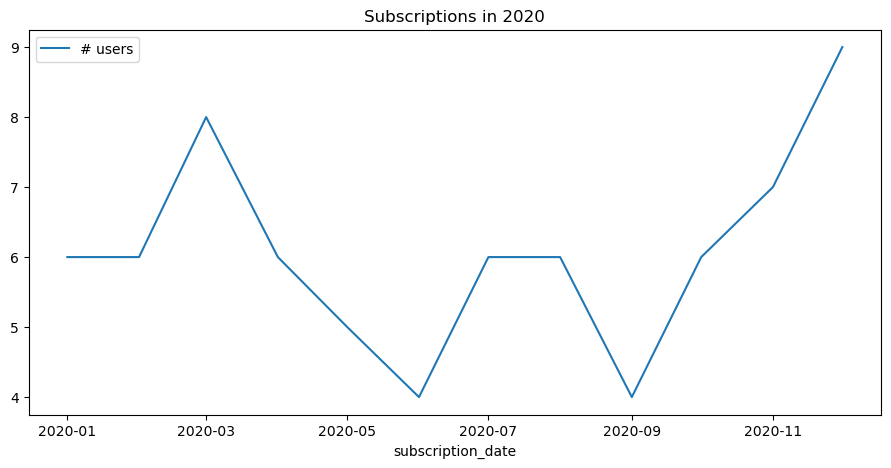

In [39]:
plot_yearly_subscription_trend(subscriptions_resampled, 2020)

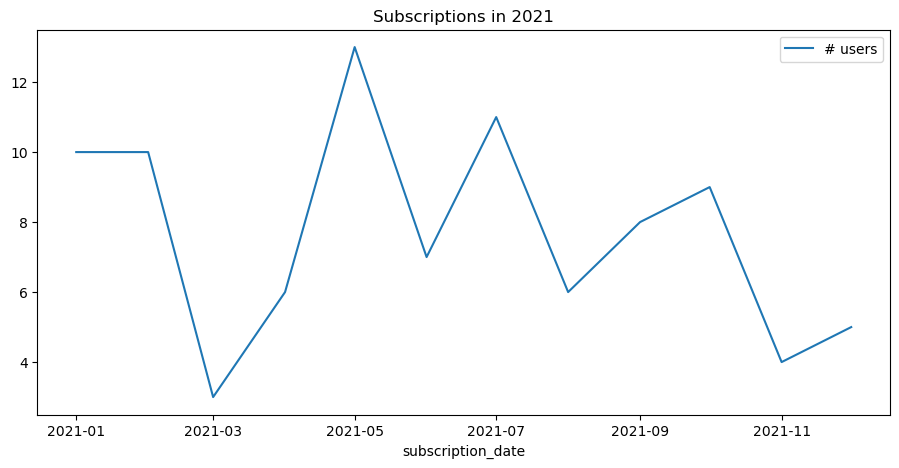

In [40]:
plot_yearly_subscription_trend(subscriptions_resampled, 2021)

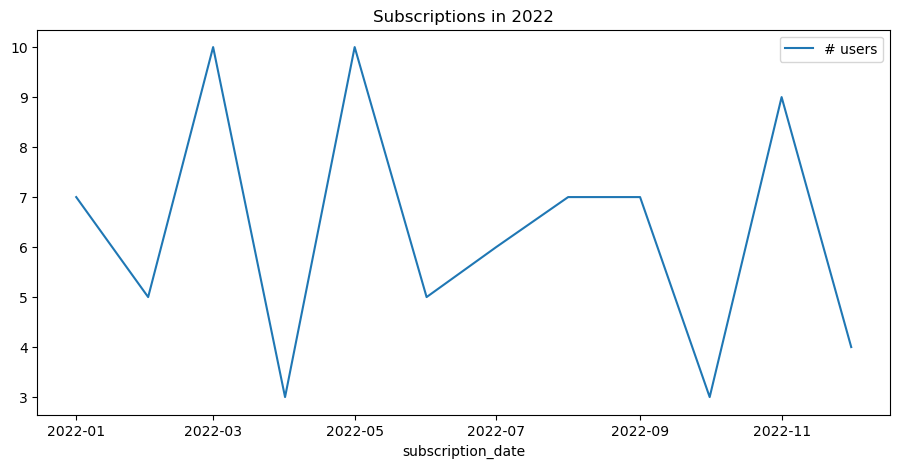

In [41]:
plot_yearly_subscription_trend(subscriptions_resampled, 2022)

Nei tre grafici precedenti, l'analisi evidenzia i differenti andamenti delle iscrizioni negli anni 2020, 2021 e 2022. Da questi grafici e dagli elementi emersi precedentemente, possiamo riassumere che:

- Nel 2020, si è osservato un trend di iscrizioni in costante crescita durante l'anno (uptrend), con un picco notevole nel mese di dicembre. Questo indica un aumento progressivo delle iscrizioni con un momento di massimo nel periodo natalizio.

- Nell'anno 2021, al contrario, si è riscontrato un trend negativo (downtrend), con un picco di iscrizioni verificatosi nel mese di maggio. Ciò suggerisce una diminuzione costante delle iscrizioni nel corso dell'anno.

- Per quanto riguarda il 2022, le iscrizioni sembrano essersi stabilizzate (horizontal trend). Tuttavia, anche in questo caso, si registrano picchi di iscrizioni nei mesi di marzo e di maggio.

## Vendite Annuali

In [42]:
purchase_by_year = fashion_data['purchase_date'].dt.year.value_counts().sort_index()
#purchase_by_year

Text(0, 0.5, 'Total')

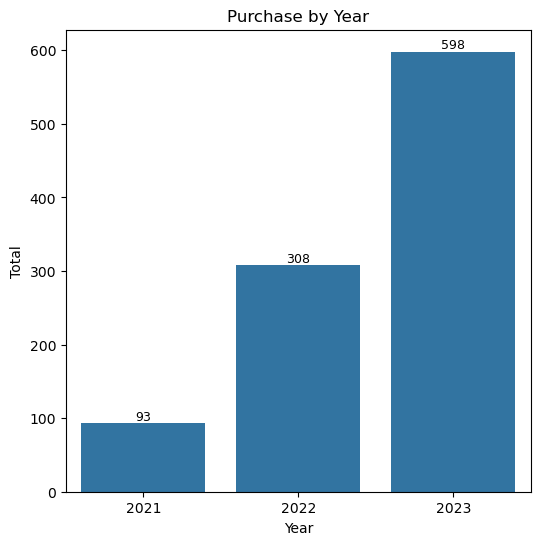

In [43]:
plt.figure(figsize = (6,6))
plt.title('Purchase by Year')
ax = sns.barplot(x = purchase_by_year.index, y = purchase_by_year, color = 'tab:blue')
ax.bar_label(ax.containers[0], fontsize=9) 
ax.set_xlabel('Year')
ax.set_ylabel('Total')

Si osserva una notevole crescita delle vendite nel corso del tempo. Le vendite sono aumentate significativamente, passando da 93 nel 2021 a 308 nel 2022 e successivamente a 598 nel 2023. La rapida crescita tra il 2021 e il 2023 suggerisce che il mercato potrebbe essere favorevole all'espansione e che ci sia potenziale per ulteriori incrementi delle vendite in futuro.
Da notare che, sommando il numero delle vendite nei tre anni, otteniamo 999, che corrisponde, come detto in precedenza, al numero delle transazioni nel dataset.

## Analisi delle Vendite

In [44]:
sales = fashion_data.loc[:, ['user_uuid', 'purchase_date', 'item_id']]
sales['purchase_date'].min(), sales['purchase_date'].max()

(Timestamp('2021-01-01 00:00:00'), Timestamp('2023-12-28 00:00:00'))

In [45]:
sales = sales.groupby('purchase_date')['item_id'].count().reset_index()
sales

,purchase_date,item_id
0,2021-01-01,1
1,2021-01-02,1
2,2021-01-03,1
3,2021-01-04,1
4,2021-01-13,2
...,...,...
576,2023-12-24,1
577,2023-12-25,5
578,2023-12-26,1
579,2023-12-27,2


In [46]:
sales = sales.set_index('purchase_date')
sales
## sales['item_id'].sum() ci da 999 quindi va bene

,item_id
purchase_date,
2021-01-01,1
2021-01-02,1
2021-01-03,1
2021-01-04,1
2021-01-13,2
...,...
2023-12-24,1
2023-12-25,5
2023-12-26,1


In [47]:
y = sales['item_id'].resample('MS').sum()
y
## La funzione resample() prende in input un dataframe e una regola di resampling. In questo caso, la regola è 'MS', 
## che indica che le vendite devono essere raggruppate per mese, con il primo giorno del mese come indice.
## y.sum() ci da 999 quindi va bene

purchase_date
2021-01-01    10
2021-02-01     7
2021-03-01     6
2021-04-01     6
2021-05-01     5
2021-06-01     8
2021-07-01     5
2021-08-01    13
2021-09-01     7
2021-10-01     6
2021-11-01    10
2021-12-01    10
2022-01-01    34
2022-02-01    22
2022-03-01    17
2022-04-01    26
2022-05-01    30
2022-06-01    32
2022-07-01    21
2022-08-01    22
2022-09-01    28
2022-10-01    21
2022-11-01    29
2022-12-01    26
2023-01-01    54
2023-02-01    48
2023-03-01    48
2023-04-01    43
2023-05-01    41
2023-06-01    53
2023-07-01    63
2023-08-01    57
2023-09-01    47
2023-10-01    39
2023-11-01    55
2023-12-01    50
Freq: MS, Name: item_id, dtype: int64

<Axes: title={'center': 'Purchase Trend'}, xlabel='purchase_date', ylabel='item_id'>

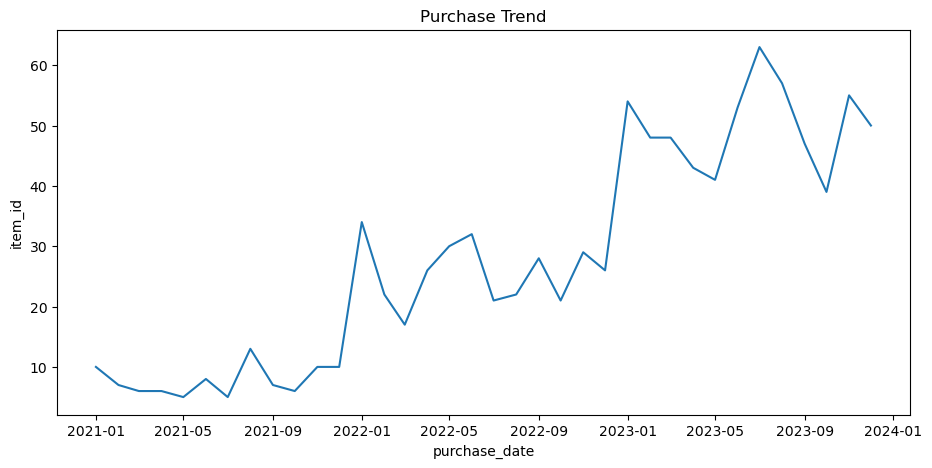

In [48]:
plt.figure(figsize = (11,5))
plt.title('Purchase Trend')
sns.lineplot(data = y)

La serie temporale nel grafico mostra l'andamento delle vendite nel tempo. Per analizzare più approfonditamente questa serie, è possibile scomporla nelle sue componenti principali al fine di comprendere meglio il trend e le stagionalità.

## Trend e Stagionalità nelle Vendite 

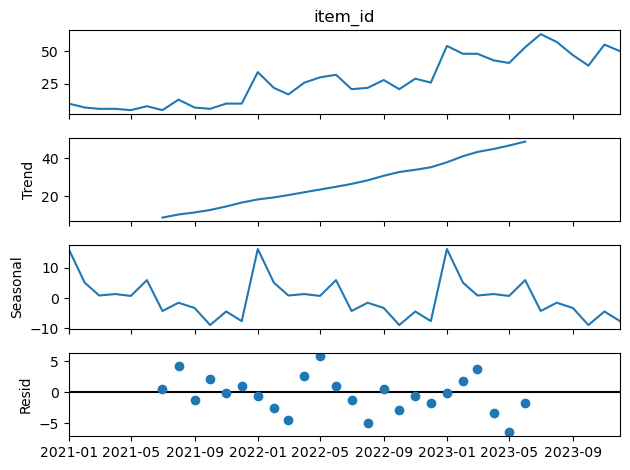

In [49]:
decomposition = seasonal_decompose(y, period = 12)
fig = decomposition.plot()
plt.show()

Dall'immagine si può dedurre che la serie temporale è caratterizzata da un trend positivo e da una stagionalità regolare.

Il trend positivo è evidente dalla componente "Trend" del grafico, che mostra un andamento crescente nel tempo. Questo indica che la serie temporale è in aumento, indipendentemente dalle fluttuazioni stagionali.
La stagionalità regolare è evidente dalla componente "Seasonal" del grafico, che mostra un andamento ciclico con un periodo di 12 mesi.

Successivamente, approfondirò l'analisi delle vendite focalizzandomi sul confronto dell'andamento mensile nel corso degli anni. L'obiettivo è individuare analogie o pattern ricorrenti che possano emergere da questa osservazione più dettagliata.

## Analisi Annuale delle Vendite: Confronto Mensile 

In [50]:
ordered_months = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

In [51]:
purchase_YM = fashion_data.groupby([fashion_data['purchase_date'].dt. year, 
                                    fashion_data['purchase_date'].dt.strftime('%B')]).size()
#purchase_YM

In [52]:
purchase_YM = purchase_YM.reindex(ordered_months, level=1)
#purchase_YM

In [53]:
purchase_YM = pd.DataFrame(purchase_YM)
purchase_YM.index.names = ['Year', 'Month']
purchase_YM = purchase_YM.rename(columns = {0 : 'Purchase'})
purchase_YM = purchase_YM.reset_index()
#purchase_YM

<Axes: title={'center': 'Sales trends over the years'}, xlabel='Month', ylabel='Purchase'>

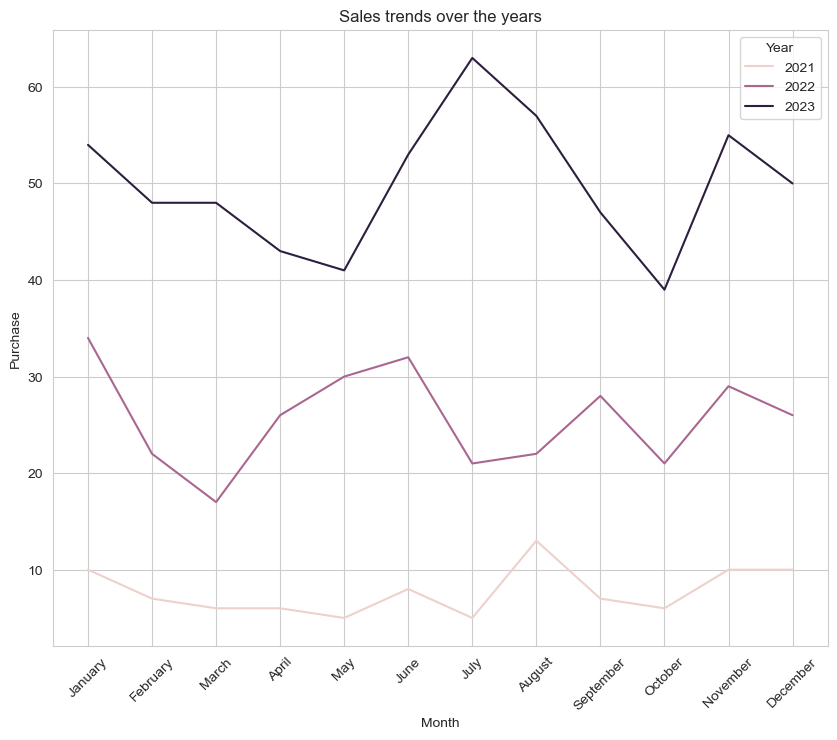

In [54]:
sns.set_style('whitegrid')
plt.figure(figsize = (10,8))
plt.title('Sales trends over the years')
plt.xticks(rotation = 45)
sns.set_style('whitegrid')
sns.lineplot(data = purchase_YM, x = 'Month', y = 'Purchase', hue = 'Year')

Dal grafico emergono i seguenti risultati:
- le vendite mostrano una costante crescita anno dopo anno.
- annualmente, si verifica un picco delle vendite durante i mesi invernali, in particolare tra novembre e gennaio, e un secondo picco durante i mesi estivi, con evidenti punte registrate ad agosto del 2021, giugno del 2022 e luglio del 2023.

## Vendite per Nazione

In [55]:
purchase_by_country = fashion_data.groupby('country').size().sort_values(ascending = False)
#purchase_by_country

[Text(0, 0, '451'), Text(0, 0, '337'), Text(0, 0, '211')]

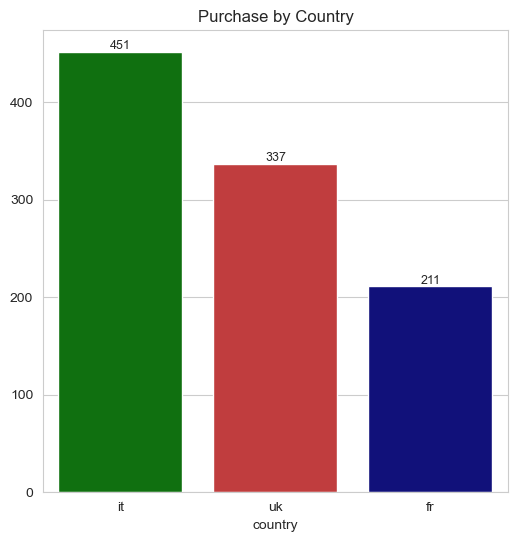

In [56]:
plt.figure(figsize = (6,6))
plt.title('Purchase by Country')
ax = sns.barplot(x = purchase_by_country.index, y = purchase_by_country, order = purchase_by_country.index.values,
                palette = ['green', 'tab:red', 'darkblue'])
ax.bar_label(ax.containers[0], fontsize=9) #ax.containers[0] indica che voglio aggiungere le etichette alle barre principali

L'Italia è la nazione in cui sono stati venduti più prodotti seguita da Regno Unito e Francia.

## Vendite per Fascia di Prezzo

In [57]:
sales_by_level = fashion_data.groupby('level').size().sort_values(ascending = False)
sales_by_level = sales_by_level.to_frame().reset_index().rename(columns = {0 : 'sales'})
sales_by_level['percentage'] = sales_by_level['sales'] / sales_by_level['sales'].sum()* 100
sales_by_level['percentage'] = sales_by_level['percentage'].round(0)
sales_by_level

,level,sales,percentage
0,premium,433,43.0
1,cheap,332,33.0
2,average,234,23.0


In [58]:
base = alt.Chart(sales_by_level).encode(
    alt.Theta("sales").stack(True),
    alt.Radius("sales").scale(type="sqrt", zero=True, rangeMin=20),
    color="level",
).properties(title = 'Sales by Price Range', width=350, height=350)

c1 = base.mark_arc(innerRadius=20, stroke="#fff")

c2 = base.mark_text(radiusOffset=10).encode(text="sales")

c1 + c2

alt.LayerChart(...)

## Vendite per Nazione e Fascia di Prezzo

vorrei provare ad usare altair per fare una grouped bar chart

In [59]:
sales_by_nation_level = fashion_data.groupby(['country', 'level']).size().to_frame().reset_index().rename(
    columns = {0 : 'sales'})
sales_by_nation_level

,country,level,sales
0,fr,average,46
1,fr,cheap,67
2,fr,premium,98
3,it,average,107
4,it,cheap,154
5,it,premium,190
6,uk,average,81
7,uk,cheap,111
8,uk,premium,145


In [60]:
alt.Chart(sales_by_nation_level).mark_bar().encode(
    column = 'country',
    x = 'level',
    y = 'sales',
    color = 'level'
).properties(title = 'Nations and Price Ranges',width=250, height=400)

alt.Chart(...)

Dall'analisi del grafico emerge che l'Italia è la nazione con il volume di vendite più elevato, seguita dal Regno Unito e dalla Francia. In tutte e tre le nazioni, la categoria di prodotti di qualità premium registra le vendite più consistenti, seguita da quella di prodotti economici (cheap) e di qualità media (average).

## Vendite per Categoria

In [61]:
sales_by_category = fashion_data.groupby('category').size().sort_values(ascending = False)
#sales_by_category

[Text(0, 0, '339'),
 Text(0, 0, '165'),
 Text(0, 0, '135'),
 Text(0, 0, '128'),
 Text(0, 0, '93'),
 Text(0, 0, '82'),
 Text(0, 0, '57')]

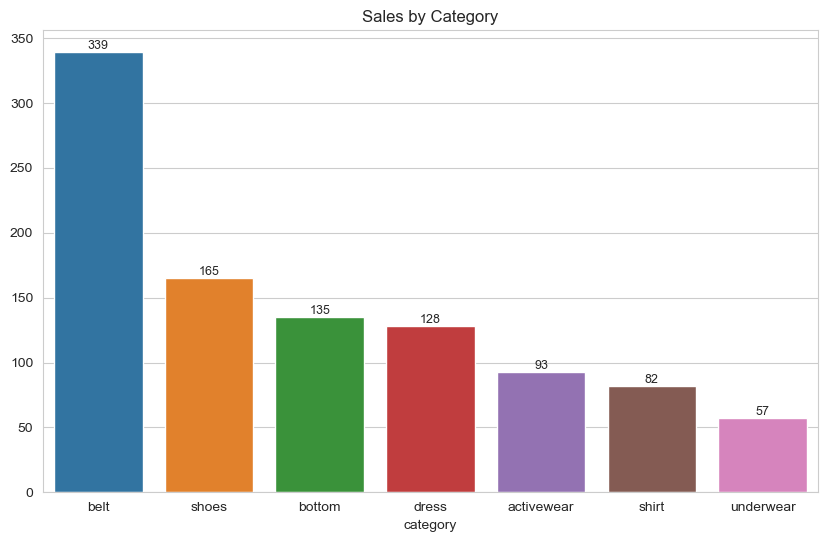

In [62]:
plt.figure(figsize = (10,6))
plt.title('Sales by Category')
ax = sns.barplot(x = sales_by_category.index, y = sales_by_category, order = sales_by_category.index.values)
ax.bar_label(ax.containers[0], fontsize=9)

La categoria di prodotti più venduta è "belt" con un totale di 339 prodotti.

## Analisi delle Vendite per Categoria

In [63]:
category_yearly = fashion_data.groupby([fashion_data['purchase_date'].dt. year, 'category']).size()
category_yearly = category_yearly.reset_index()
category_yearly = category_yearly.rename(columns = {0 : 'sales'})
category_yearly

,purchase_date,category,sales
0,2021,activewear,10
1,2021,belt,27
2,2021,bottom,13
3,2021,dress,13
4,2021,shirt,9
...,...,...,...
16,2023,bottom,90
17,2023,dress,76
18,2023,shirt,46
19,2023,shoes,103


<Axes: title={'center': 'Annual Sales'}, xlabel='purchase_date', ylabel='sales'>

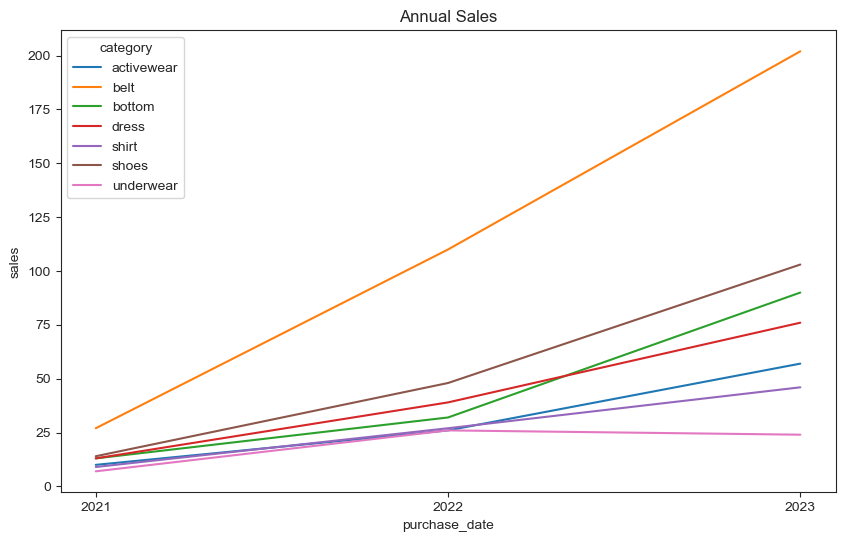

In [64]:
sns.set_style('ticks')
plt.figure(figsize= (10,6))
plt.title('Annual Sales')
plt.xticks([2021, 2022, 2023])
sns.lineplot(data = category_yearly, x = 'purchase_date', y = 'sales', hue = 'category')

Tutte le categorie, ad eccezione di "underwear", hanno registrato una crescita nelle vendite nel corso degli anni.

## Heat Map: Vendite per Categoria e Mese

In [65]:
fashion_data.groupby('category').size()

category
activewear     93
belt          339
bottom        135
dress         128
shirt          82
shoes         165
underwear      57
dtype: int64

In [66]:
def category_by_month(db):
    january = fashion_data.loc[fashion_data['purchase_date'].dt.month == 1]
    left = january.groupby('category').size().to_frame().rename(columns = {0: 1})
    for mese in range(2, 13):
        db_month = db.loc[db['purchase_date'].dt.month == mese]
        cat_by_month_prov = db_month.groupby('category').size().to_frame().rename(columns = {0: mese})
        left = left.join(cat_by_month_prov)
    return(left)

In [67]:
categories_sold_by_month = category_by_month(fashion_data)
#categories_sold_by_month

<Axes: title={'center': 'Sales by Category Across Months'}, ylabel='category'>

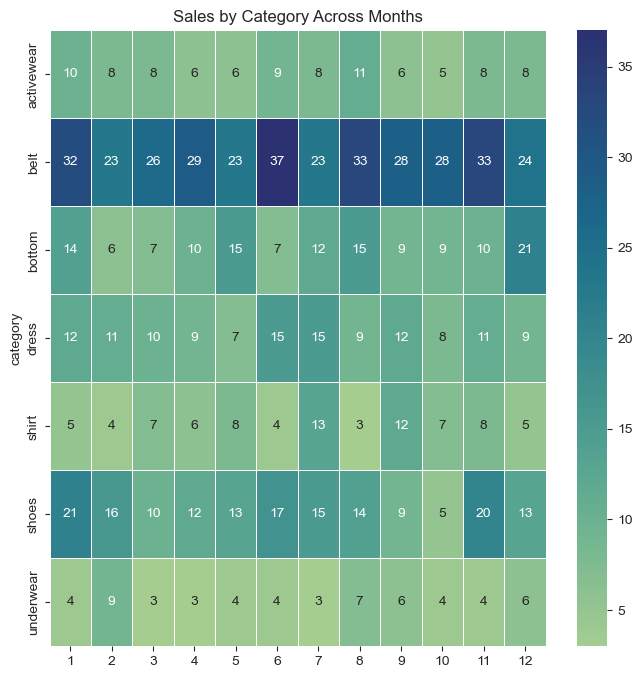

In [68]:
plt.figure(figsize = (8,8))
plt.title('Sales by Category Across Months')
sns.heatmap(categories_sold_by_month, annot = True, linewidth=.5, cmap="crest")

Al fine di ottenere un'analisi più chiara e sintetica, procederò a realizzare lo stesso grafico, ma raggruppando le vendite per stagioni.

## Heat Map: Vendite per Categoria e Stagione

In [69]:
def category_by_season(db):
    winter = [12, 1, 2]
    spring = [3, 4, 5]
    summer = [6, 7, 8]
    autumn = [9, 10, 11]
    
    # inizializzo left usando come stagione winter prima di inserirlo nel ciclo for con le restanti stagioni
    winter_bool = db['purchase_date'].dt.month.isin(winter)
    winter_df = db.loc[winter_bool, ['category', 'purchase_date', 'item_id']]
    left = winter_df.groupby('category')['item_id'].count().sort_values(ascending=False).to_frame().rename(columns = 
                                                                                                           {'item_id': 'winter'})
    
    seasons = {'spring' : spring, 'summer' : summer, 'autumn' : autumn}
    
    for key, value in seasons.items():
        season_bool = db['purchase_date'].dt.month.isin(value)
        season_df = db.loc[season_bool, ['category', 'purchase_date', 'item_id']]
        category_season = season_df.groupby('category')['item_id'].count().sort_values(ascending=False).to_frame().rename(
            columns = {'item_id' : key})
        left = left.join(category_season)

    return(left)

In [70]:
categories_sold_by_season = category_by_season(fashion_data)
categories_sold_by_season

,winter,spring,summer,autumn
category,,,,
belt,79,78,93,89
shoes,50,35,46,34
bottom,41,32,34,28
dress,32,26,39,31
activewear,26,20,28,19
underwear,19,10,14,14
shirt,14,21,20,27


<Axes: title={'center': 'Sales by Category Across Seasons'}, ylabel='category'>

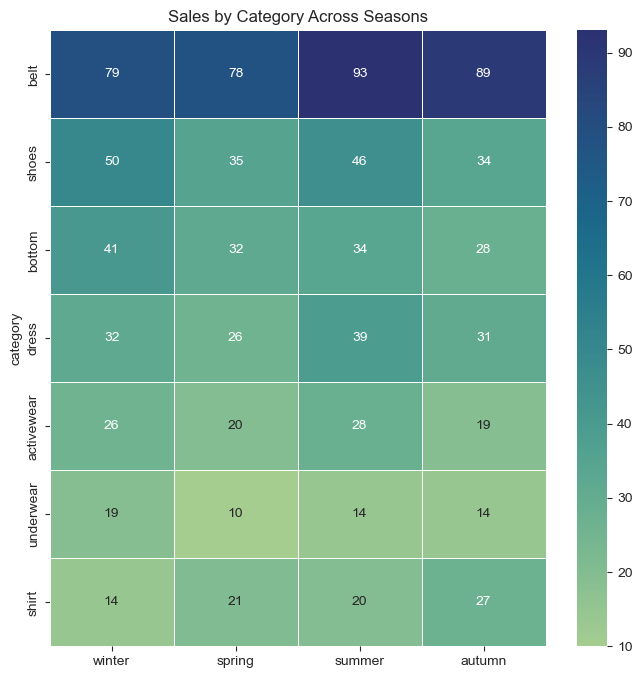

In [71]:
plt.figure(figsize = (8,8))
plt.title('Sales by Category Across Seasons')
sns.heatmap(categories_sold_by_season, annot = True, linewidth=.5, cmap="crest")

Dalle informazioni fornite dalla heatmap, possiamo dedurre che le vendite seguono determinati pattern stagionali:
- la categoria "belt" registra il massimo delle vendite durante l'estate e l'autunno, emergendo come la più performante in ogni stagione
- "shoes" registra un picco di vendite sia in inverno che in estate
- la categoria "bottom" riscontra un aumento delle vendite durante la stagione invernale
- "dress" è più popolare durante l'estate
- "activewear" mostra una tendenza positiva nelle vendite sia in inverno che in estate
- la categoria "underwear" risulta particolarmente richiesta durante l'inverno
- "shirt" sembra essere più venduta durante l'autunno

## Vendite Stagionali

In [72]:
categories_sold_by_season.sum().to_frame()

,0
winter,261
spring,222
summer,274
autumn,242


[Text(0, 0, '261'), Text(0, 0, '222'), Text(0, 0, '274'), Text(0, 0, '242')]

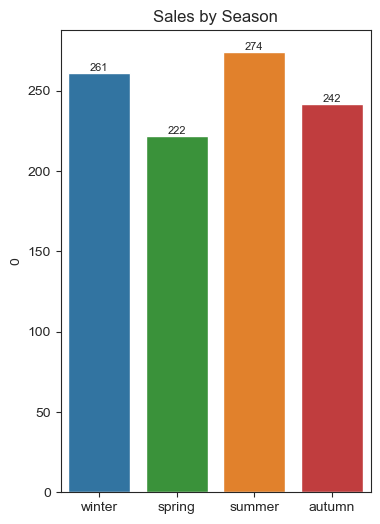

In [73]:
plt.figure(figsize=(4,6))
plt.title('Sales by Season')
ax = sns.barplot(x = categories_sold_by_season.sum().to_frame().index, y = categories_sold_by_season.sum().to_frame()[0],
                palette = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red'])
ax.bar_label(ax.containers[0], fontsize=8)

La stagione in cui si registrano più vendite è l'estate, seguita dall'inverno, autunno e primavera.

## Top Designer di Prodotti

Per valutare i designer, terrò conto sia del numero dei loro prodotti che della valutazione media di tali prodotti. Questa analisi comprenderà una valutazione equilibrata, considerando sia la quantità che la qualità dei loro prodotti.

In [74]:
designer_items = fashion_data.groupby('designer_id').size()
designer_items.name = 'items'
#designer_items

In [75]:
len(designer_items) #numero di designer nel database

23

In [76]:
designer_stars_avg = fashion_data.groupby('designer_id')['stars'].mean()
#designer_stars_avg

In [77]:
designer_rank = pd.concat([designer_items, designer_stars_avg], axis = 1)
designer_rank

,items,stars
designer_id,,
100,41,3.170732
101,46,3.021739
102,53,3.018868
103,46,2.913043
104,39,3.179487
...,...,...
118,31,3.096774
119,44,2.681818
120,34,2.852941


In [78]:
alt.Chart(designer_rank.reset_index()).mark_circle(size=60).encode(
    x='items',
    y='stars',
    #color='designer_id',
    tooltip=['designer_id', 'items', 'stars']
).interactive().properties(title = 'Designer Insights: Quantity vs Quality', width=500, height=400)

alt.Chart(...)

## Quantità vs Qualità

Calcolerò la matrice di correlazione per esaminare se esiste una relazione tra il numero dei prodotti e la loro valutazione media per i designer. Questo ci aiuterà a comprendere meglio la possibile connessione tra la quantità di lavori realizzati e la qualità media delle valutazioni ricevute dai designer.

<Axes: >

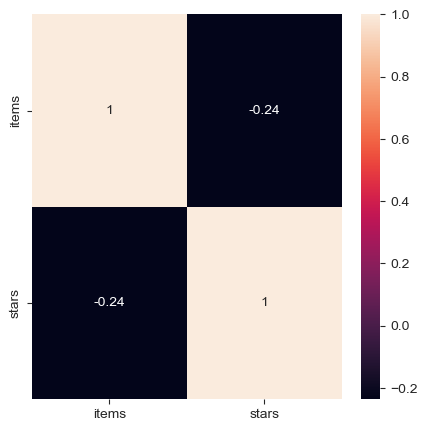

In [79]:
correlation_matrix_designer = designer_rank.corr()
plt.figure(figsize = (5,5))
sns.heatmap(correlation_matrix_designer, annot = True)

Una correlazione di -0.24 tra il numero di vendite per un designer e la media delle stelle assegnate ai suoi prodotti suggerisce che c'è una debole correlazione negativa tra questi due fattori. In altre parole, quando il numero di vendite di un designer aumenta, la media delle stelle assegnate ai suoi prodotti tende leggermente a diminuire, e viceversa.

Ciò potrebbe suggerire che i designer più popolari potrebbero affrontare una maggiore variabilità nelle valutazioni dei loro prodotti, forse dovuta a un pubblico più ampio o alle aspettative più elevate. D'altra parte, designer meno conosciuti potrebbero avere un pubblico più ristretto e fedele che è incline a dare valutazioni più alte.

## Best Designers

In [80]:
designer_rank.sort_values(by = ['items', 'stars'], ascending = False).head(10)

,items,stars
designer_id,,
110,54,3.185185
102,53,3.018868
117,52,2.903846
105,51,2.784314
113,48,2.916667
101,46,3.021739
103,46,2.913043
106,46,2.913043
112,46,2.826087


## Pagamenti per piattaforma

In [81]:
users_platform = fashion_data.groupby('platform').size().sort_values(ascending = False)
#users_platform

[Text(0, 0, '458'), Text(0, 0, '330'), Text(0, 0, '211')]

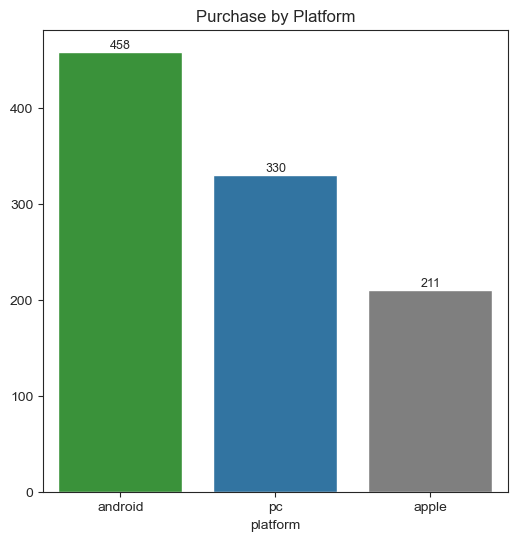

In [82]:
plt.figure(figsize= (6,6))
plt.title('Purchase by Platform')
#plt.pie(users_platform.values, labels = users_platform.index)
ax = sns.barplot(x = users_platform.index, y = users_platform, order = users_platform.index.values,
                palette = ['tab:green', 'tab:blue', 'tab:grey'])
ax.bar_label(ax.containers[0], fontsize=9)

L'immagine evidenzia che la piattaforma più utilizzata per effettuare pagamenti è Android, seguita da PC e Apple.

## Tempo Trascorso tra Iscrizione e Prima Transazione

Nelle piattaforme di e-commerce, è normale che trascorra un certo periodo di tempo tra l'iscrizione dell'utente sulla piattaforma e la sua prima interazione o vendita. Valutare il tempo tipicamente impiegato dagli utenti, attraverso l'analisi dei dati storici, è essenziale per adottare strategie di marketing differenziate in base al comportamento degli utenti.

In [83]:
# Calcolo la differenza di tempo tra la prima vendita e l'iscrizione per ogni utente
delay_dt = fashion_data.loc[:, ['user_uuid', 'subscription_date', 'purchase_date']]
delay_dt

,user_uuid,subscription_date,purchase_date
0,183,2021-08-20,2022-07-13
1,134,2022-11-20,2023-05-02
2,158,2020-03-18,2021-08-06
3,82,2022-01-21,2023-07-18
4,201,2022-11-25,2023-05-07
...,...,...,...
994,3,2020-07-22,2023-06-07
995,81,2022-08-23,2023-11-10
996,173,2021-12-12,2023-11-22
997,41,2021-08-01,2023-12-12


In [84]:
delay_dt = delay_dt.groupby(['user_uuid', 'subscription_date'])['purchase_date'].min().reset_index()
delay_dt

,user_uuid,subscription_date,purchase_date
0,1,2021-05-20,2022-10-09
1,2,2022-01-06,2023-04-21
2,3,2020-07-22,2021-03-18
3,4,2022-05-10,2023-07-16
4,5,2022-01-25,2023-03-10
...,...,...,...
236,241,2022-05-11,2023-07-19
237,242,2021-10-06,2022-09-15
238,243,2020-08-24,2021-04-20
239,244,2021-05-25,2022-03-04


In [85]:
delay_dt = delay_dt.set_index('user_uuid')
delay_dt

,subscription_date,purchase_date
user_uuid,,
1,2021-05-20,2022-10-09
2,2022-01-06,2023-04-21
3,2020-07-22,2021-03-18
4,2022-05-10,2023-07-16
5,2022-01-25,2023-03-10
...,...,...
241,2022-05-11,2023-07-19
242,2021-10-06,2022-09-15
243,2020-08-24,2021-04-20


In [86]:
delay_dt = delay_dt.rename(columns = {'purchase_date' : '1st_purchase_date'})
delay_dt

,subscription_date,1st_purchase_date
user_uuid,,
1,2021-05-20,2022-10-09
2,2022-01-06,2023-04-21
3,2020-07-22,2021-03-18
4,2022-05-10,2023-07-16
5,2022-01-25,2023-03-10
...,...,...
241,2022-05-11,2023-07-19
242,2021-10-06,2022-09-15
243,2020-08-24,2021-04-20


In [87]:
delay_dt['month_delay'] = ((delay_dt['1st_purchase_date'] - delay_dt['subscription_date'])/np.timedelta64(1, 'M')).astype('int')
delay_dt

,subscription_date,1st_purchase_date,month_delay
user_uuid,,,
1,2021-05-20,2022-10-09,16
2,2022-01-06,2023-04-21,15
3,2020-07-22,2021-03-18,7
4,2022-05-10,2023-07-16,13
5,2022-01-25,2023-03-10,13
...,...,...,...
241,2022-05-11,2023-07-19,14
242,2021-10-06,2022-09-15,11
243,2020-08-24,2021-04-20,7


In [88]:
delay_dt['month_delay'].describe()

count    241.000000
mean      11.460581
std        7.246803
min        0.000000
25%        7.000000
50%       11.000000
75%       14.000000
max       41.000000
Name: month_delay, dtype: float64

- Conteggio (Count): Indica che ci sono 241 campioni relativi al periodo di latenza delle vendite degli utenti, il che è corretto poiché coincide con il numero degli utenti iscritti nel dataset in questione.

- Media (Mean): Questo significa che, in media, gli utenti impiegano circa 11.5 mesi dalla loro iscrizione alla piattaforma per effettuare la loro prima vendita.

- Deviazione Standard (Std): La deviazione standard è di circa 7.25 mesi. Questo valore misura la dispersione dei dati rispetto alla media. Un valore di deviazione standard più alto indica una maggiore variabilità nei periodi di latenza.

- Valore Minimo (Min): Il valore minimo nel campione è 0 mesi, il che indica che ci sono utenti che effettuano la loro prima vendita poco tempo dopo l'iscrizione.

- Primo Quartile (25%): Il 25% dei dati ha un periodo di latenza inferiore a 7 mesi.

- Mediana (50%): Significa che il 50% dei dati ha un periodo di latenza inferiore a 11 mesi e il restante 50% ha un periodo di latenza superiore a 11 mesi.

- Terzo Quartile (75%): Il 75% dei dati ha un periodo di latenza inferiore a 14 mesi.

- Valore Massimo (Max): Il valore massimo nel campione è di 41 mesi, il che indica che ci sono utenti che effettuano la loro prima vendita quasi dopo due anni dalla loro iscrizione.

Text(0.5, 0, 'Delay (in months)')

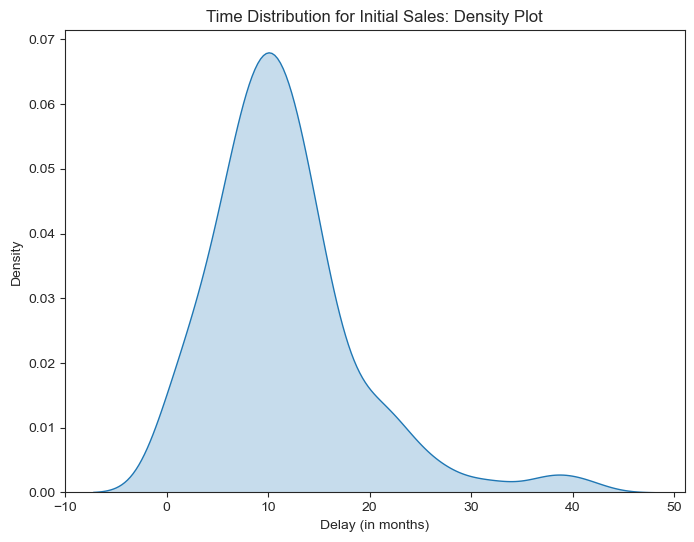

In [89]:
sns.set_style('ticks')
plt.figure(figsize= (8,6))
plt.title('Time Distribution for Initial Sales: Density Plot')
sns.kdeplot(data = delay_dt, x = 'month_delay',fill = True)
plt.xlabel('Delay (in months)')

La deviazione standard mette in luce la diversità nel comportamento degli utenti all'interno della curva di distribuzione. In particolare, possiamo notare:

- La presenza di utenti che iniziano a vendere poco tempo dopo l'iscrizione (con un valore minimo di 0 mesi), indicando che alcuni utenti sono pronti ad impegnarsi immediatamente sulla piattaforma, il che è positivo.

- La presenza di utenti che mostrano un periodo di latenza molto lungo prima di iniziare a partecipare attivamente sulla piattaforma.

Per incrementare l'utilizzo della piattaforma e, di conseguenza, aumentare il volume delle vendite, potremmo adottare diverse strategie di marketing, come ad esempio:

- Offrire offerte speciali o programmi di fidelizzazione per gli utenti che sono pronti ad impegnarsi immediatamente sulla piattaforma.

- Fornire supporto agli utenti che non effettuano la loro prima vendita entro 14 mesi, cercando di stimolarli con un conto speciale per i costi di pubblicazione di nuovi prodotti o uno sconto sulle commissioni per le vendite effettuate entro un determinato periodo.

## Classificazione Utenti: Abituali vs Occasionali

Suddividerò gli utenti iscritti in due gruppi, in base al numero di transazioni:
- Utenti Occasionali (con un numero limitato di vendite)
- Utenti Abituali (con un numero significativo di vendite)

Questa divisione ci permetterà di personalizzare le strategie di coinvolgimento per massimizzare l'interazione e i profitti della piattaforma.

In [90]:
#Cluster numero di vendite: 2 
sales_by_user = fashion_data.groupby('user_uuid').size().sort_values(ascending = False)
sales_by_user = sales_by_user.to_frame().rename(columns = {0 : 'sales'})
sales_by_user

,sales
user_uuid,
182,11
131,10
190,10
119,10
225,9
...,...
214,1
85,1
68,1


In [91]:
kmeans = KMeans(n_clusters = 2, n_init = 10)

In [92]:
kmeans.fit(sales_by_user)

KMeans(n_clusters=2, n_init=10)

In [93]:
kmeans.cluster_centers_

array([[6.30107527],
       [2.79054054]])

In [94]:
print(kmeans.labels_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [95]:
print(len(kmeans.labels_))

241


In [96]:
sales_by_user['cluster'] = kmeans.labels_
sales_by_user

,sales,cluster
user_uuid,,
182,11,0
131,10,0
190,10,0
119,10,0
225,9,0
...,...,...
214,1,1
85,1,1
68,1,1


In [97]:
sales_by_user['cluster'].value_counts().to_dict()

{1: 148, 0: 93}

Dopo l'applicazione dell'algoritmo di classificazione K-Means, sono emersi due gruppi distinti: uno composto da 93 utenti abituali e l'altro da 148 utenti occasionali. Poiché il numero di utenti occasionali è superiore rispetto a quelli abituali, potrebbe essere vantaggioso concentrarsi su strategie di coinvolgimento mirate per aumentare l'utilizzo della piattaforma da parte di questa fascia più ampia di utenti. 

## Confronto dei Tempi di Ritardo: Utenti Abituali e Occasionali

Come precedentemente indicato, desidero confrontare il periodo di tempo tra l'iscrizione alla piattaforma e l'effettuazione della prima vendita, concentrandomi sui due gruppi di utenti, ossia quelli occasionali e quelli abituali. Questo aspetto temporale riveste un'importanza cruciale nel comprendere appieno il comportamento degli utenti e nell'identificare eventuali modelli d'utilizzo.
Effettuerò un join tra il dataset contenente i cluster e quello relativo alla prima vendita, per poi realizzare un confronto attraverso un grafico delle distribuzioni.

In [98]:
delay_clusters = sales_by_user.join(delay_dt)
delay_clusters

,sales,cluster,subscription_date,1st_purchase_date,month_delay
user_uuid,,,,,
182,11,0,2020-03-14,2021-06-11,14
131,10,0,2022-03-26,2023-01-18,9
190,10,0,2021-06-28,2022-02-01,7
119,10,0,2022-08-25,2023-02-20,5
225,9,0,2020-12-25,2021-01-19,0
...,...,...,...,...,...
214,1,1,2020-03-24,2022-06-28,26
85,1,1,2020-03-28,2023-07-07,38
68,1,1,2020-12-14,2022-09-25,20


Text(0.5, 0, 'Ritardo (in Mesi)')

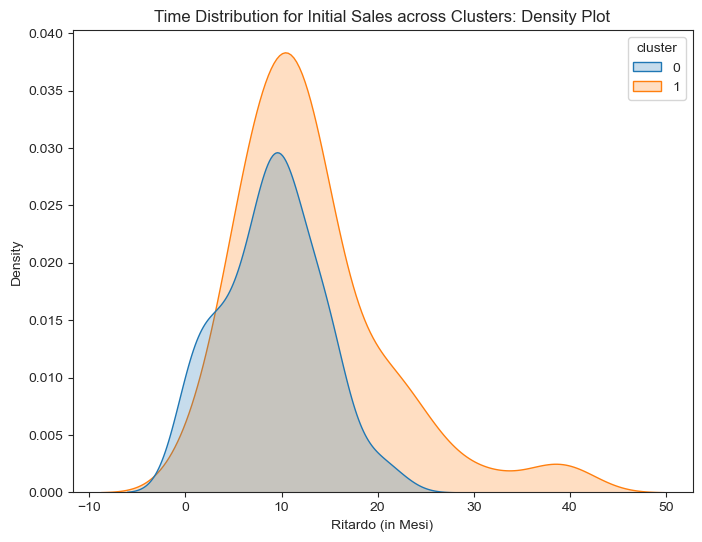

In [99]:
sns.set_style('ticks')
plt.figure(figsize= (8,6))
plt.title('Time Distribution for Initial Sales across Clusters: Density Plot')
sns.kdeplot(data = delay_clusters, x = 'month_delay',fill = True, hue = 'cluster')
plt.xlabel('Ritardo (in Mesi)')

- Gli utenti abituali (cluster 0) presentano una distribuzione più concentrata per il ritardo tra la prima vendita e la registrazione al sito. La maggioranza degli utenti abituali ha effettuato la prima vendita entro i primi 10 mesi dalla registrazione (area sottesa dalla curva).

- Gli utenti occasionali (cluster 1), al contrario, mostrano una curva distribuzione molto più ampia. La maggioranza degli utenti occasionali ha inoltre effettuato la prima vendita dopo i 12 mesi, con un secondo picco dopo i 30 mesi dalla registrazione.

In sintesi, questi risultati suggeriscono che gli utenti abituali sono più propensi a effettuare la prima vendita precocemente, mentre gli utenti occasionali, apparentemente più restii, mostrano una maggiore variabilità del momento in cui effettuano la prima vendita.